In [1]:
using DifferentialEquations, Plots, ForwardDiff, StaticArrays, LaTeXStrings, LinearAlgebra

## Double Pendulum

![double pendulum](https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg)

Dynamics of a double pendulum, adapted from [this tutorial by Ryan C. Cooper (2024)](https://cooperrc.github.io/Julia-learning/day_06.html), for the dynamics $\dot{u} = f(u,t)$ of the state $u=[\theta_1,\theta_2,\dot{\theta}_1,\dot{\theta}_2]$, described  by the system of ODEs:

1. $\left(m_1L_1^2 + m_2L_1^2\right)\ddot{\theta}_1 + m_2L_1L_2\cos\left(\theta_1 - \theta_2\right)\ddot{\theta}_2 +m_2L_1L_2\dot{\theta}_2^2\sin\left(\theta_1 - \theta_2) + (m_1gL_1 + m_2 g L_1\right)\sin\theta_1$

2. $m_2L_1L_2\cos\left(\theta_1 - \theta_2\right)\ddot{\theta}_1 + m_2L_2\ddot{\theta}_2 - m_2L_1L_2\dot{\theta}_1^2\sin\left(\theta_1-\theta_2\right) +m_2gL_2\sin\theta_2$

Note that, at each step, we need to solve a $2 \times 2$ linear system of equations to determine $[\ddot{\theta}_1, \ddot{\theta}_2]$ from $[\theta_1,\theta_2,\dot{\theta}_1,\dot{\theta}_2]$.  I use the [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl) package in Julia, which allows us to deal extremely efficiently with small fixed-size vectors and matrices like the ones here (allowing the compiler to specialize all the code for the specific matrix and vector sizes here).

In [2]:
function doublependulum(u, params, t)
    g = 9.81
    (; l1, l2, m1, m2) = params
    
    M = @SMatrix[l1*(m1+m2)                   m2*l1*l2*cos(u[1] - u[2])
                 m2*l1*l2*cos(u[1] - u[2])    m2*l2]
    rhs = @SVector[-m2*l2*u[4]^2*sin(u[1] - u[2]) - (m1+m2)*g*sin(u[1]),
                   m2*l1*l2*u[3]^2*sin(u[1] - u[2]) - m2*g*l2*sin(u[2])]
    θ̈ = M \ rhs
    du = @SVector[u[3], u[4], θ̈[1], θ̈[2]]
    return du
end

doublependulum (generic function with 1 method)

This system is **chaotic** , so even a tiny change in the initial conditions leads to an exponentially growing change int he solution:

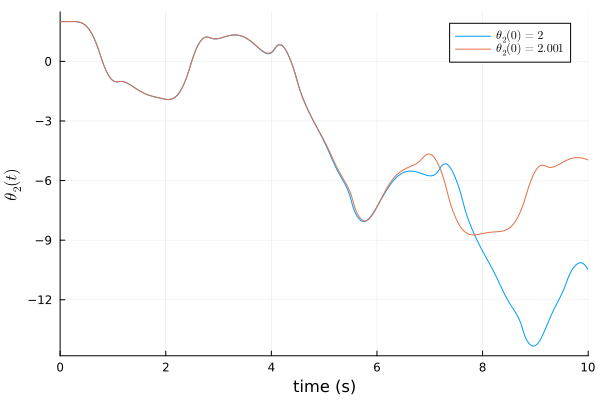

In [3]:

tspan = (0, 10);
p = (; l1=1, l2=1, m1=0.1, m2=0.1)

prob1 = ODEProblem(doublependulum, @SVector[2, 2.0, 0, 0], tspan, p)
sol1 = solve(prob1, reltol = 1e-10)
prob2 = ODEProblem(doublependulum, @SVector[2, 2.001, 0, 0], tspan, p)
sol2 = solve(prob2, reltol = 1e-10)

plot(sol1, idxs=2, label=L"\theta_2(0) = 2")
plot!(sol2, idxs=2, label=L"\theta_2(0) = 2.001")
plot!(xlabel="time (s)", ylabel=L"\theta_2(t)")

## Sensitivity to initial conditions (forward mode)

Let the initial conditions (IC) be $u(0)=b$.   If we want the Jacobian $J = \partial u / \partial b$ as a function of time, it satisfies:
$$
\frac{\partial J}{\partial t} = \frac{\partial f}{\partial u} J
$$
with initial condition $J(0) = \frac{\partial u(0)}{\partial b} = I$.   Note that this is a *linear* ODE, but the system matrix $\frac{\partial f}{\partial u}$ is time-varying so the answer is not a matrix exponential.

Since we are solving this forward-mode, we can evolve $(u, J)$ at the same time, concatenating them into a vector of $4 + 4^2 = 20$ entries: that is, we solve a *single* system of 20 coupled ODEs.

In [4]:
function doublependulum_∂IC(uJ, params, t)
    # extract u and J from uJ
    u = SVector(ntuple(i -> uJ[i], Val(4)))
    J = reshape(SVector(ntuple(i -> uJ[i + 4], Val(16))), Size(4,4))

    du = doublependulum(u, params, t)
    dJ = ForwardDiff.jacobian(u -> doublependulum(u, params, t), u) * J
    return [du; vec(dJ)]
end

doublependulum_∂IC (generic function with 1 method)

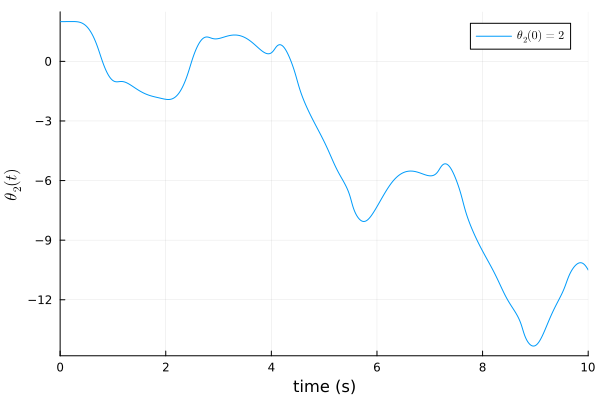

In [5]:
I₄ = @SMatrix[1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1]

prob_diff = ODEProblem(doublependulum_∂IC, [@SVector[2, 2.0, 0, 0]; vec(I₄)], tspan, p)
sol_diff = solve(prob_diff, reltol = 1e-10)

plot(sol_diff, idxs=2, label=L"\theta_2(0) = 2")
plot!(xlabel="time (s)", ylabel=L"\theta_2(t)")

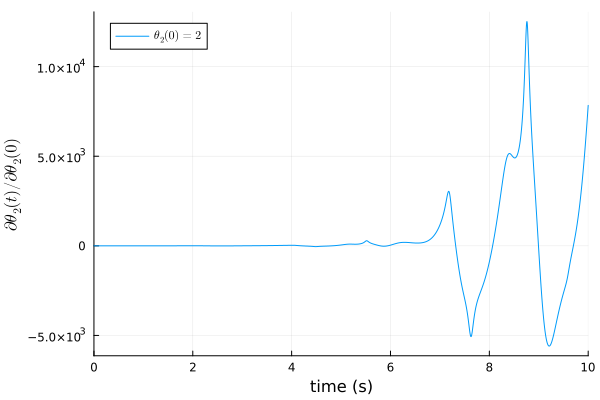

In [6]:

plot(sol_diff, idxs=10, label=L"\theta_2(0) = 2")
plot!(xlabel="time (s)", ylabel=L"\partial\theta_2(t)/\partial\theta_2(0)")

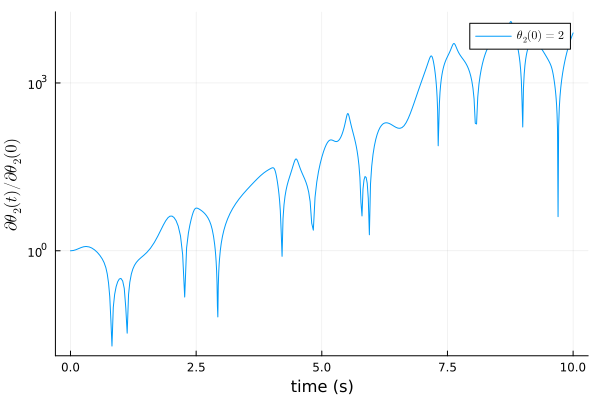

In [7]:

plot(sol_diff.t, abs.(sol_diff[10,:]), label=L"\theta_2(0) = 2", yaxis=:log)
plot!(xlabel="time (s)", ylabel=L"\partial\theta_2(t)/\partial\theta_2(0)")

### Finite-difference check:

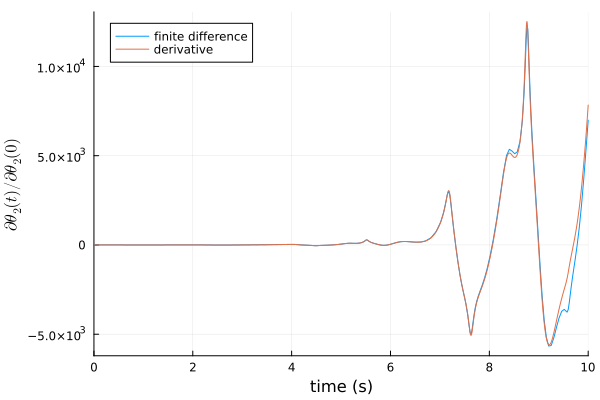

In [8]:
prob1_delta = ODEProblem(doublependulum, @SVector[2, 2 + 1e-5, 0, 0], tspan, p)
sol1_delta = solve(prob1_delta, reltol = 1e-10)

dθ₂ = sol1_delta(sol1.t)[2,:] - sol1[2,:]
plot(sol1.t, dθ₂ / 1e-5, label="finite difference")
plot!(sol_diff, idxs=10, label="derivative")
plot!(xlabel="time (s)", ylabel=L"\partial\theta_2(t)/\partial\theta_2(0)")

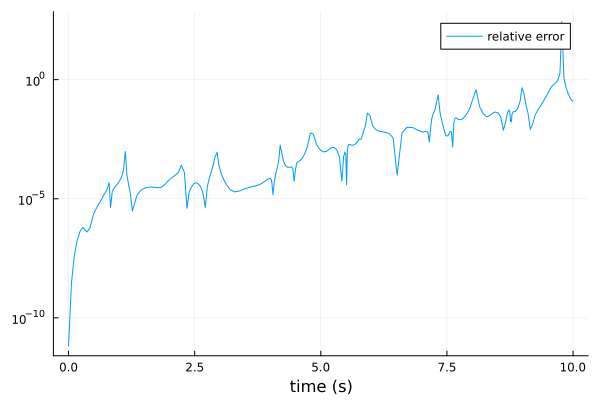

In [9]:

plot(sol1.t, abs.(dθ₂ - 1e-5 * sol_diff(sol1.t)[10,:]) ./ abs.(dθ₂),
    label="relative error", yaxis=:log, xlabel="time (s)")

Hooray, the finite-difference check matches to about five digits, although the difference grows with time thanks to the chaotic nature of this problem.

(Five digits is about all we can expect here, thanks to a combination of the truncatio error from using a $\delta \theta_2(0) = 10^{-5}$ and the fact that we "only" requested the solution to 10 digits.)